# NFW Profiles

This notebook demonstrates the NFW (Navarro-Frenk-White) halo profile calculations available in the `halox` library. We'll explore the key properties and methods of the `NFWHalo` class.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from halox import cosmology, nfw

jax.config.update("jax_enable_x64", True)

plt.style.use(["seaborn-v0_8-darkgrid", "petroff10"])
plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in"})

## Setting up the Cosmology

First, let's create a cosmology object using the Planck 2018 parameters provided by halox:

In [2]:
# Create a Planck 2018 cosmology
cosmo = cosmology.Planck18()
print(f"Hubble parameter h = {cosmo.h}")
print(f"Matter density Ω_m = {cosmo.Omega_m}")
print(f"Baryon density Ω_b = {cosmo.Omega_b}")
print(f"Cold dark matter density Ω_c = {cosmo.Omega_c}")
print(f"Power spectrum normalization σ_8 = {cosmo.sigma8}")

Hubble parameter h = 0.6766
Matter density Ω_m = 0.30964
Baryon density Ω_b = 0.04897
Cold dark matter density Ω_c = 0.26067
Power spectrum normalization σ_8 = 0.8102


## Creating an NFW Halo

Now let's create an NFW halo with specific mass, concentration, and redshift parameters:

In [3]:
# Halo parameters
m_200 = 1e14  # Mass in h^-1 M_sun
c_200 = 10.0  # Concentration parameter
z = 0.0  # Redshift
delta = 200.0  # Overdensity relative to critical density

# Create the NFW halo
halo = nfw.NFWHalo(m_200, c_200, z, cosmo, delta=delta)

print(f"Halo mass M_200 = {halo.m_delta:.2e} h^-1 M_sun")
print(f"Concentration c_200 = {halo.c_delta}")
print(f"Virial radius R_200 = {halo.Rdelta:.3f} h^-1 Mpc")
print(f"Scale radius R_s = {halo.Rs:.3f} h^-1 Mpc")
print(f"Characteristic density ρ_0 = {halo.rho0:.2e} h^2 M_sun Mpc^-3")

Halo mass M_200 = 1.00e+14 h^-1 M_sun
Concentration c_200 = 10.0
Virial radius R_200 = 0.755 h^-1 Mpc
Scale radius R_s = 0.075 h^-1 Mpc
Characteristic density ρ_0 = 1.24e+16 h^2 M_sun Mpc^-3


## Density Profile

The NFW density profile is given by:

$$\rho(r) = \frac{\rho_0}{\frac{r}{R_s}\left(1 + \frac{r}{R_s}\right)^2}$$

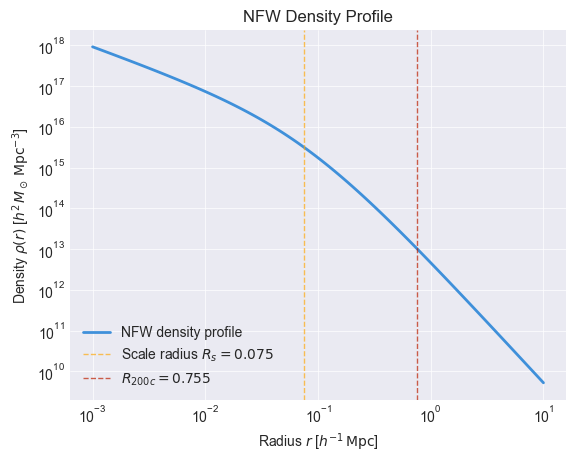

In [4]:
# Create radial grid
r = jnp.logspace(-3, 1, 100)  # From 0.001 to 10 h^-1 Mpc

# Compute density profile
rho = halo.density(r)

# Plot
fig, ax = plt.subplots()
ax.loglog(r, rho, linewidth=2, label="NFW density profile")
ax.axvline(
    halo.Rs,
    color="C1",
    linestyle="--",
    alpha=0.7,
    label=f"Scale radius $R_s = {halo.Rs:.3f}$",
)
ax.axvline(
    halo.Rdelta,
    color="C2",
    linestyle="--",
    alpha=0.7,
    label=f"$R_{{200c}} = {halo.Rdelta:.3f}$",
)
ax.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax.set_ylabel(r"Density $\rho(r)$ [$h^2 \, M_\odot \, {\rm Mpc}^{-3}$]")
ax.set_title("NFW Density Profile")
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Enclosed Mass Profile

The enclosed mass within radius $r$ is:

$$M(<r) = 4\pi \rho_0 R_s^3 \left[\ln\left(1 + \frac{r}{R_s}\right) - \frac{r}{r + R_s}\right]$$

M(<R_200c) = 1.00e+14 h^-1 M_sun
M_200c = 1.00e+14 h^-1 M_sun


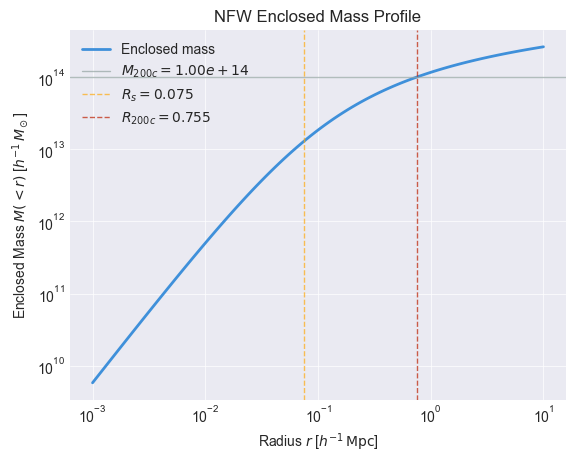

In [5]:
# Compute enclosed mass profile
m_enc = halo.enclosed_mass(r)

# Plot
fig, ax = plt.subplots()
ax.loglog(r, m_enc, linewidth=2, label="Enclosed mass")
ax.axhline(
    halo.m_delta,
    color="C3",
    linestyle="-",
    alpha=0.7,
    label=f"$M_{{200c}} = {halo.m_delta:.2e}$",
)
ax.axvline(
    halo.Rs,
    color="C1",
    linestyle="--",
    alpha=0.7,
    label=f"$R_s = {halo.Rs:.3f}$",
)
ax.axvline(
    halo.Rdelta,
    color="C2",
    linestyle="--",
    alpha=0.7,
    label=f"$R_{{200c}} = {halo.Rdelta:.3f}$",
)
ax.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax.set_ylabel(r"Enclosed Mass $M(<r)$ [$h^{-1} \, M_\odot$]")
ax.set_title("NFW Enclosed Mass Profile")
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

# Verify that M(<R_200) = M_200
m_at_r200 = halo.enclosed_mass(halo.Rdelta)
print(f"M(<R_200c) = {m_at_r200:.2e} h^-1 M_sun")
print(f"M_200c = {halo.m_delta:.2e} h^-1 M_sun")

## Gravitational Potential

The gravitational potential is:

$$\phi(r) = -4\pi G \rho_0 R_s^3 \frac{\ln\left(1 + \frac{r}{R_s}\right)}{r}$$

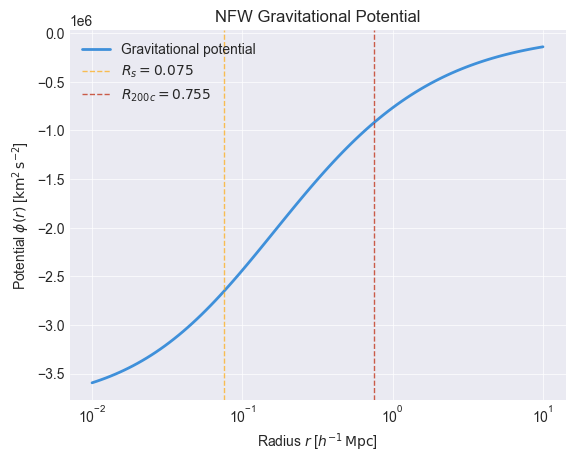

In [6]:
# Compute potential profile (excluding very small radii to avoid divergence)
r_pot = jnp.logspace(-2, 1, 100)  # From 0.01 to 10 h^-1 Mpc
phi = halo.potential(r_pot)

# Plot
fig, ax = plt.subplots()
ax.semilogx(r_pot, phi, linewidth=2, label="Gravitational potential")
ax.axvline(
    halo.Rs,
    color="C1",
    linestyle="--",
    alpha=0.7,
    label=f"$R_s = {halo.Rs:.3f}$",
)
ax.axvline(
    halo.Rdelta,
    color="C2",
    linestyle="--",
    alpha=0.7,
    label=f"$R_{{200c}} = {halo.Rdelta:.3f}$",
)
ax.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax.set_ylabel(r"Potential $\phi(r)$ [${{\rm km}}^2 \, {\rm s}^{-2}$]")
ax.set_title("NFW Gravitational Potential")
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Circular Velocity Profile

The circular velocity is related to the enclosed mass by:

$$v_c(r) = \sqrt{\frac{GM(<r)}{r}}$$

Circular velocity at R_s = 859.8 km/s
Circular velocity at R_200c = 754.8 km/s


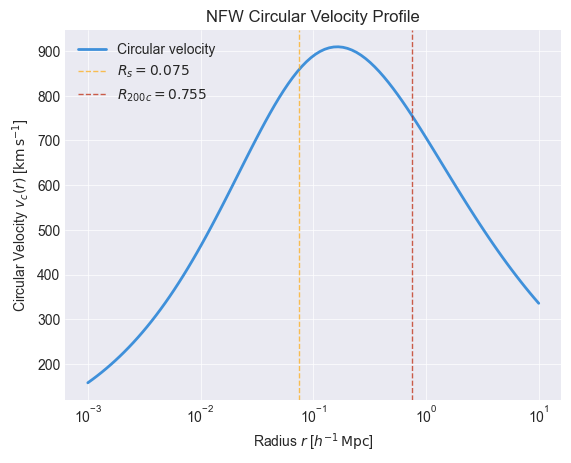

In [7]:
# Compute circular velocity profile
v_c = halo.circular_velocity(r)

# Plot
fig, ax = plt.subplots()
ax.semilogx(r, v_c, linewidth=2, label="Circular velocity")
ax.axvline(
    halo.Rs,
    color="C1",
    linestyle="--",
    alpha=0.7,
    label=f"$R_s = {halo.Rs:.3f}$",
)
ax.axvline(
    halo.Rdelta,
    color="C2",
    linestyle="--",
    alpha=0.7,
    label=f"$R_{{200c}} = {halo.Rdelta:.3f}$",
)
ax.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax.set_ylabel(r"Circular Velocity $v_c(r)$ [${{\rm km}} \, {\rm s}^{-1}$]")
ax.set_title("NFW Circular Velocity Profile")
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

# Print some characteristic values
v_c_at_rs = halo.circular_velocity(halo.Rs)
v_c_at_r200 = halo.circular_velocity(halo.Rdelta)
print(f"Circular velocity at R_s = {v_c_at_rs:.1f} km/s")
print(f"Circular velocity at R_200c = {v_c_at_r200:.1f} km/s")

## Velocity Dispersion Profile

The radial velocity dispersion for an NFW profile assuming isotropic orbits is given by the analytical solution from Lokas & Mamon (2001):

$$\sigma_r^2(r) = \frac{1}{\rho(r)} \int_r^{\infty} \rho(s) \frac{GM(<s)}{s^2} ds$$

This integral has a closed-form solution for NFW profiles.

Velocity dispersion at R_s = 202.4 km/s
Velocity dispersion at R_200c = 3.2 km/s


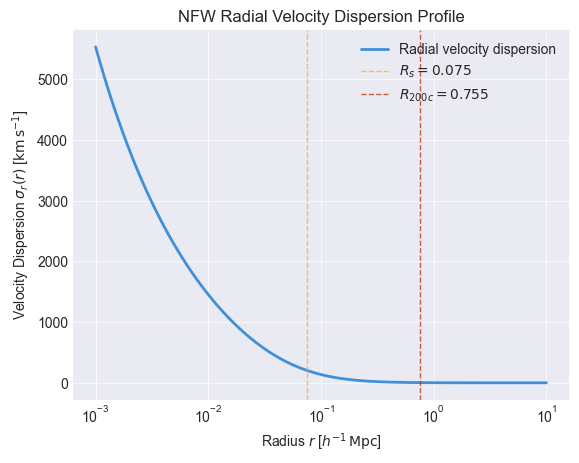

In [8]:
# Compute velocity dispersion profile
sigma_r = halo.velocity_dispersion(r)

# Plot
fig, ax = plt.subplots()
ax.semilogx(r, sigma_r, linewidth=2, label="Radial velocity dispersion")
ax.axvline(
    halo.Rs,
    color="C1",
    linestyle="--",
    alpha=0.7,
    label=f"$R_s = {halo.Rs:.3f}$",
)
ax.axvline(
    halo.Rdelta,
    color="C2",
    linestyle="--",
    alpha=0.7,
    label=f"$R_{{200c}} = {halo.Rdelta:.3f}$",
)
ax.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax.set_ylabel(
    r"Velocity Dispersion $\sigma_r(r)$ [${{\rm km}} \, {\rm s}^{-1}$]"
)
ax.set_title("NFW Radial Velocity Dispersion Profile")
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

# Print some characteristic values
sigma_r_at_rs = halo.velocity_dispersion(halo.Rs)
sigma_r_at_r200 = halo.velocity_dispersion(halo.Rdelta)
print(f"Velocity dispersion at R_s = {sigma_r_at_rs:.1f} km/s")
print(f"Velocity dispersion at R_200c = {sigma_r_at_r200:.1f} km/s")

## Surface Density Profile

The projected surface density is obtained by integrating the 3D density profile along the line of sight:

$$\Sigma(r) = 2 \int_r^{\infty} \frac{\rho(s) s \, ds}{\sqrt{s^2 - r^2}}$$

For NFW profiles, this integral has a closed-form analytical solution (Bartelmann 1996).

Surface density at R_s = 6.25e+14 h M_sun Mpc^-2
Surface density at R_200c = 1.62e+13 h M_sun Mpc^-2


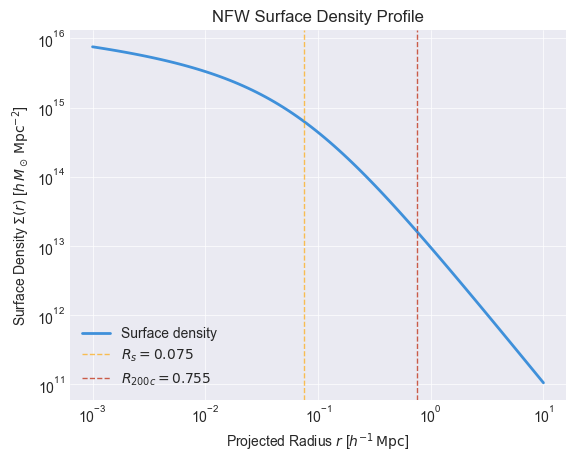

In [9]:
# Compute surface density profile
sigma_surf = halo.surface_density(r)

# Plot
fig, ax = plt.subplots()
ax.loglog(r, sigma_surf, linewidth=2, label="Surface density")
ax.axvline(
    halo.Rs,
    color="C1",
    linestyle="--",
    alpha=0.7,
    label=f"$R_s = {halo.Rs:.3f}$",
)
ax.axvline(
    halo.Rdelta,
    color="C2",
    linestyle="--",
    alpha=0.7,
    label=f"$R_{{200c}} = {halo.Rdelta:.3f}$",
)
ax.set_xlabel(r"Projected Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax.set_ylabel(
    r"Surface Density $\Sigma(r)$ [$h \, M_\odot \, {\rm Mpc}^{-2}$]"
)
ax.set_title("NFW Surface Density Profile")
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

# Print some characteristic values
sigma_surf_at_rs = halo.surface_density(halo.Rs)
sigma_surf_at_r200 = halo.surface_density(halo.Rdelta)
print(f"Surface density at R_s = {sigma_surf_at_rs:.2e} h M_sun Mpc^-2")
print(f"Surface density at R_200c = {sigma_surf_at_r200:.2e} h M_sun Mpc^-2")

## Vectorization

The `NFWHalo` class supports vectorized operations, allowing you to work with multiple halos simultaneously:

In [10]:
def rho(r, m, c, z, cosmo=cosmo, delta=200.0):
    return nfw.NFWHalo(m, c, z, cosmo=cosmo, delta=delta).density(r)


# Create multiple halos with different masses and concentrations
masses = jnp.array([1e13, 1e14, 1e15])  # h-1 M_sun
concentrations = jnp.array([12.0, 10.0, 8.0])
redshifts = jnp.array([0.5, 0.2, 0.1])
radii = jnp.logspace(-3, 1, 64)  # h-1 Mpc

rhos = jax.vmap(rho, in_axes=[None, 0, 0, 0, None, None])(
    radii, masses, concentrations, redshifts, cosmo, delta
)

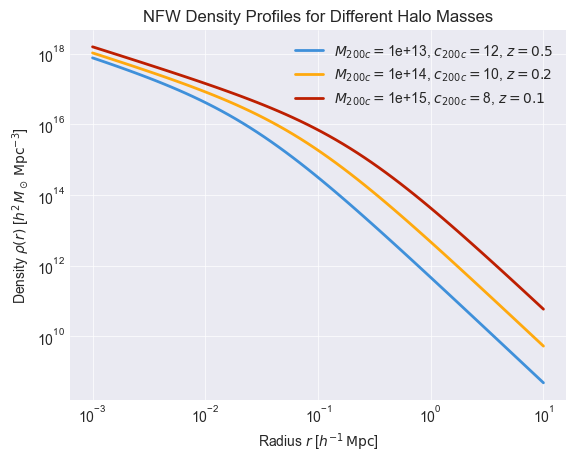

In [11]:
# Plot density profiles for all halos
fig, ax = plt.subplots()

for i in range(len(masses)):
    ax.loglog(
        radii,
        rhos[i],
        lw=2,
        label="$M_{200c}=$"
        + f"{masses[i]:.0e}, "
        + "$c_{200c}=$"
        + f"{concentrations[i]:.0f}, "
        + f"$z={redshifts[i]:.1f}$",
    )

ax.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax.set_ylabel(r"Density $\rho(r)$ [$h^2 \, M_\odot \, {\rm Mpc}^{-3}$]")
ax.set_title("NFW Density Profiles for Different Halo Masses")
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Different overdensities

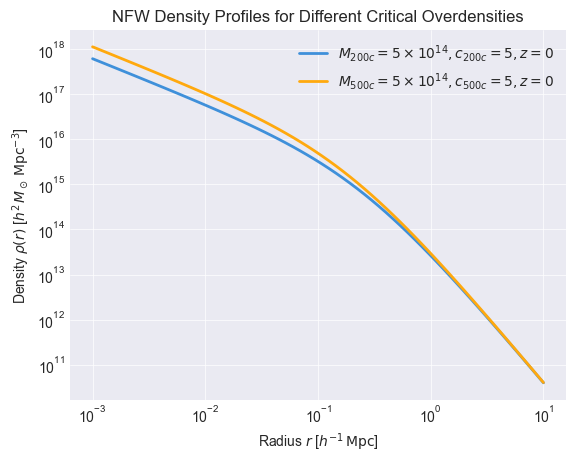

In [12]:
fig, ax = plt.subplots()
r = jnp.logspace(-3, 1, 64)

for delta in [200.0, 500.0]:
    rho = nfw.NFWHalo(5e14, 5.0, 0.0, cosmo=cosmo, delta=delta).density(r)
    d = f"{delta:.0f}c"
    ax.loglog(
        r,
        rho,
        lw=2,
        label=f"$M_{{{d}}}=5 \\times 10^{{14}}, c_{{{d}}}=5, z=0$",
    )

ax.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax.set_ylabel(r"Density $\rho(r)$ [$h^2 \, M_\odot \, {\rm Mpc}^{-3}$]")
ax.set_title("NFW Density Profiles for Different Critical Overdensities")
ax.legend()
ax.xaxis.set_ticks_position("both")
ax.yaxis.set_ticks_position("both")
ax.grid(True, alpha=1.0)

## Acceleration

In [13]:
cosmo = cosmology.Planck18()


def rho(r, m, c, z, cosmo=cosmo, delta=200.0):
    return nfw.NFWHalo(m, c, z, cosmo=cosmo, delta=delta).density(r)


rs = jnp.logspace(-3, 1, 64)

Not compiling the function:

In [14]:
%timeit _ = rho(rs, 1e14, 5.0, 0.0)

530 μs ± 17.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Compiling the function and executing it once to get rid of compilation overhead:

In [15]:
rho_j = jax.jit(rho)
_ = rho_j(rs, 1e14, 5.0, 0.0)
%timeit _ = rho_j(rs, 1e14, 5.0, 0.0)

10.8 μs ± 83.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
